In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes
from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [4]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [5]:
sudmant_df = (
    pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')
    .with_columns(
        pl.col("sample_set").cast(pl.String),
        pl.col("sample_id").cast(pl.String),
    )
)

In [6]:
%%time
reads_filenames = (
    [
        (
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        (
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]
)

9it [00:00, 44202.27it/s]
6it [00:00, 40136.88it/s]

CPU times: user 33.3 ms, sys: 4.38 ms, total: 37.6 ms
Wall time: 29 ms


## Subset of reads with at least 4 SNPs

In [7]:
%%time

def F(filename):
    return (
        pl.scan_parquet(filename)
        .select(
            'read_name',
            'read_length',
            'chrom',
            'sample_id',
            'grch37_chromosome_size_in_bp',
            'high_quality_snp_positions',
            'CO_active_interval_start',
            'CO_active_interval_end',
            'CO_active_interval_length_bp',
            'grch37_reference_start',
            'grch38_reference_start',
            'grch37_reference_end',
            'grch38_reference_end',
            'grch37_reference_start_cM',
            'grch37_reference_end_cM',
            'CO_active_interval_start_cM',
            'CO_active_interval_end_cM',
            'CO_active_interval_crossover_prob',
            "mid_CO_active_interval_crossover_prob",
            "full_read_crossover_prob",
            'AA_motif_center_pos',
            'AA_heat',
            'AA_motif_strand',
            'CL4_motif_center_pos',
            'CL4_heat',
            'CL4_motif_strand',
            'is_high_quality_read',
            "min_coverage_hap1",
            "min_coverage_hap2",
            "high_quality_classification_class",
            "snp_positions_on_read", 
            "idx_transitions",
            "H3K4me3_signal_mean",
            "CTCF_signal_sum",
            "CTCF_signal_mean",
            "high_quality_classification_in_detectable_class",
            "total_mismatches",
        )
        .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")        # Remove if you need all
        .filter(pl.col("high_quality_snp_positions").list.len() >= 4)
        .filter("is_high_quality_read")
        .filter(pl.col("CO_active_interval_crossover_prob") > 0)
        .collect(streaming=True)
    )

dense_reads_with_detection_df = pl.concat(
    joblib.Parallel(n_jobs=-1, verbose=1)(
        joblib.delayed(F)(filename) for filename in reads_filenames
    )
)

/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.8s
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short

CPU times: user 924 ms, sys: 546 ms, total: 1.47 s
Wall time: 39.3 s


[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:   39.3s finished


# # of events, expected vs. observed

Carefully constrain the set of reads for this analysis:

* Only reads with sufficient coverage, to (over)account for the effect of filtering for coverage between switches
* Only high quality reads
* We can allow 4 SNPs

In [12]:
possible_CO_subset_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 4)
    .filter("is_high_quality_read")
    .filter(pl.col("mid_CO_active_interval_crossover_prob") > 0)
    .filter(pl.col("min_coverage_hap1") >= 3)
    .filter(pl.col("min_coverage_hap2") >= 3)
)



In [13]:
def get_obs_exp(df):
    n_observed_COs = len(df.filter(pl.col("high_quality_classification_class") == "CO"))
    
    ps = df["mid_CO_active_interval_crossover_prob"].to_numpy()

    # Expected is \sum_{p}
    mean_expected_COs = ps.sum()

    # Variance is \sum_{p(1-p)}
    std_expected_COs = (ps*(1-ps)).sum()**0.5
    
    return {
        "n_observed_COs": n_observed_COs,
        "mean_expected_COs": mean_expected_COs,
        "std_expected_COs": std_expected_COs,
    }
    
    

In [14]:
get_obs_exp(possible_CO_subset_df)

{'n_observed_COs': 6808,
 'mean_expected_COs': np.float64(7705.302982050088),
 'std_expected_COs': np.float64(87.72780297017624)}

In [15]:
get_obs_exp(possible_CO_subset_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids)))

{'n_observed_COs': 4468,
 'mean_expected_COs': np.float64(5209.312253696138),
 'std_expected_COs': np.float64(72.133936892154)}

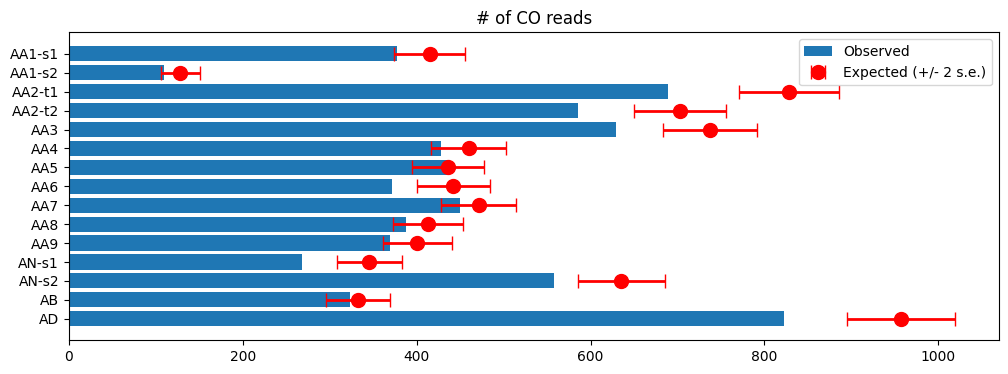

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))

for i, sample_id in enumerate(sample_presentation_order[:-1]):
    d = get_obs_exp(possible_CO_subset_df.filter(pl.col("sample_id") == sample_id))
    
    ax.barh(
        y = i,
        width = d["n_observed_COs"],
        color = "C0",        
    );
    
    ax.errorbar(
        x = d["mean_expected_COs"],
        y = i,
        xerr = d["std_expected_COs"] * 2,
        color = "red",
        ms = 10,
        fmt='o',
        elinewidth = 2,
        capsize = 5,
    );
    
ax.invert_yaxis()
ax.set_yticks(np.arange(len(sample_presentation_order[:-1])), [sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]]);
ax.legend(["Observed", "Expected (+/- 2 s.e.)"]);
ax.set_title("# of CO reads");
    

## Only Rahbari, split by platform

In [10]:
%%time
rahbari_reads_flow_cells_df = pl.read_parquet(
    "/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_name_to_flow_cell.parquet"
)

CPU times: user 28.2 s, sys: 18.5 s, total: 46.7 s
Wall time: 15.3 s


In [11]:
%%time
rahbari_possible_CO_subset_with_flow_cell_df = (possible_CO_subset_df
    .join(rahbari_reads_flow_cells_df, on=["read_name", "sample_id"])
    .join(rahbari_df.select("flow_cell", "flow_cell_type"), on="flow_cell")
)

CPU times: user 3min 8s, sys: 2min 6s, total: 5min 15s
Wall time: 1min 27s


### Just SequelII

PD50508b
PD50508f
PD46180c
PD50519d
PD50477f
PD50489e
1894
3898
7899
95619
115980
PD50521b
PD50521e
2895
PD50523b


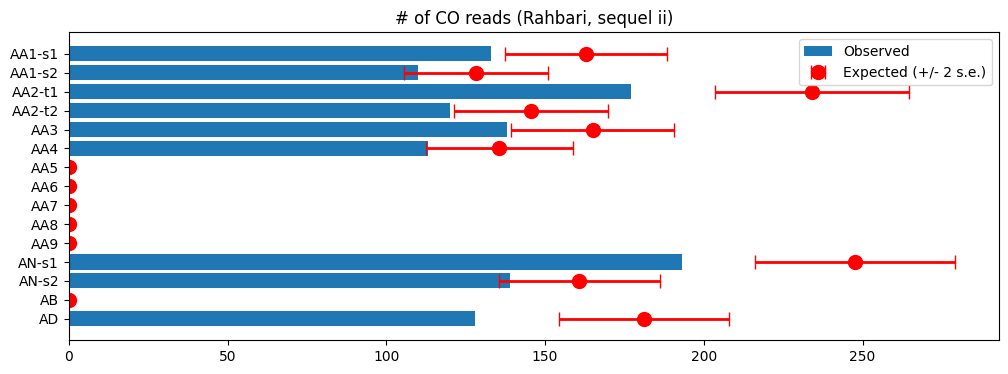

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))

for i, sample_id in enumerate(sample_presentation_order[:-1]):
    print(sample_id)
    df = (rahbari_possible_CO_subset_with_flow_cell_df
        .filter(pl.col("sample_id") == sample_id)
        .filter(pl.col("flow_cell_type") == "sequel_ii")
    )
    d = get_obs_exp(df)
    
    ax.barh(
        y = i,
        width = d["n_observed_COs"],
        color = "C0",        
    );
    
    ax.errorbar(
        x = d["mean_expected_COs"],
        y = i,
        xerr = d["std_expected_COs"] * 2,
        color = "red",
        ms = 10,
        fmt='o',
        elinewidth = 2,
        capsize = 5,
    );
    
ax.invert_yaxis()
ax.set_yticks(np.arange(len(sample_presentation_order[:-1])), [sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]]);
ax.legend(["Observed", "Expected (+/- 2 s.e.)"]);
ax.set_title("# of CO reads (Rahbari, sequel ii)");
    

### Revio

PD50508b
PD50508f
PD46180c
PD50519d
PD50477f
PD50489e
1894
3898
7899
95619
115980
PD50521b
PD50521e
2895
PD50523b


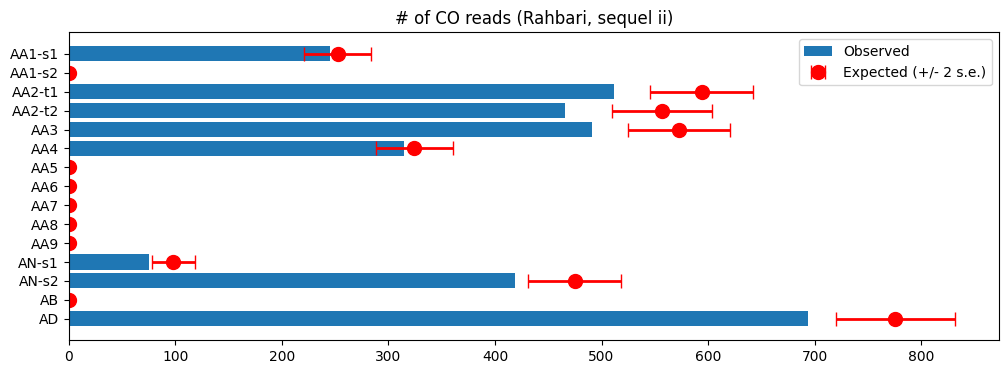

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))

for i, sample_id in enumerate(sample_presentation_order[:-1]):
    print(sample_id)
    df = (rahbari_possible_CO_subset_with_flow_cell_df
        .filter(pl.col("sample_id") == sample_id)
        .filter(pl.col("flow_cell_type") == "revio_unbinned")
    )
    d = get_obs_exp(df)
    
    ax.barh(
        y = i,
        width = d["n_observed_COs"],
        color = "C0",        
    );
    
    ax.errorbar(
        x = d["mean_expected_COs"],
        y = i,
        xerr = d["std_expected_COs"] * 2,
        color = "red",
        ms = 10,
        fmt='o',
        elinewidth = 2,
        capsize = 5,
    );
    
ax.invert_yaxis()
ax.set_yticks(np.arange(len(sample_presentation_order[:-1])), [sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]]);
ax.legend(["Observed", "Expected (+/- 2 s.e.)"]);
ax.set_title("# of CO reads (Rahbari, sequel ii)");
    

# Overall rates

In [8]:
CO_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
    .with_columns(
        grch37_recombining_interval_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_recombining_interval_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_recombining_interval_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_recombining_interval_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
    )
    .with_columns(
        grch37_recombining_interval_length = pl.col("grch37_recombining_interval_end_pos") - pl.col("grch37_recombining_interval_start_pos"),                
        grch38_recombining_interval_length = pl.col("grch38_recombining_interval_end_pos") - pl.col("grch38_recombining_interval_start_pos"),                
    )
)

dfs = []
for [chrom], df in CO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_recombining_interval_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_start_pos"]) * 1e2,
            grch37_recombining_interval_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_end_pos"]) * 1e2,
        ).with_columns(
            grch37_recombining_interval_cM = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")),
            grch37_cM_per_bp_across_recombining_interval = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")) / pl.col("grch37_recombining_interval_length"),
        )
    )
    
CO_df = pl.concat(dfs)

In [9]:
len(CO_df)

6033

### Add flow cell information

In [21]:
read_name_to_flow_cell_df = pl.concat([
    (
        pl.scan_csv(
            str(Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212")
                    / f"alignments/{R['sample_set']}/{R['sample_id']}/{R['flow_cell']}/T2T_reference/" \
                    / "minimap2.sorted.primary_alignments.ref_starts.csv.gz"),
            has_header=False,
            separator=',',
        )
        .rename({f"column_{i+1}": name for i, name in enumerate(["read_name", "chrom", "pos"])})            
        .with_columns(
            sample_set = pl.lit(R['sample_set']),
            sample_id = pl.lit(R['sample_id']),
            flow_cell = pl.lit(R['flow_cell']),
        )
        .select("read_name", "sample_set", "sample_id", "flow_cell")
    )
            for R in list(rahbari_df.iter_rows(named=True))
] + [
    (
        pl.scan_csv(
            str(Path("/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121")
                    / f"alignments/{R['sample_set']}/{R['sample_id']}/{R['flow_cell']}/T2T_reference/" \
                    / "minimap2.sorted.primary_alignments.ref_starts.csv.gz"),
            has_header=False,
            separator=',',
        )
        .rename({f"column_{i+1}": name for i, name in enumerate(["read_name", "chrom", "pos"])})            
        .with_columns(
            sample_set = pl.lit(R['sample_set']),
            sample_id = pl.lit(R['sample_id']),
            flow_cell = pl.lit(R['flow_cell']),
        )
        .select("read_name", "sample_set", "sample_id", "flow_cell")
    )
            for R in list(sudmant_df.iter_rows(named=True))    
])

In [22]:
%%time
CO_with_flow_cells_df = (CO_df.lazy()
    .join(read_name_to_flow_cell_df.select("read_name", "flow_cell"), on=["read_name"])
    .collect(streaming=True)
    .join(
        pl.concat([
            rahbari_df.select("flow_cell", "flow_cell_type"),
            sudmant_df.select("flow_cell", "flow_cell_type"),
        ]),
        on="flow_cell",
    )
)                         

CPU times: user 1min 30s, sys: 22.8 s, total: 1min 53s
Wall time: 1min 36s


## cM/Mb rates

### cM/Mb across CO interval

In [19]:
(CO_df["grch37_cM_per_bp_across_recombining_interval"]*1e6).mean()

29.329306315300176

In [23]:
(CO_with_flow_cells_df.filter(pl.col("flow_cell_type") == "sequel_ii")["grch37_cM_per_bp_across_recombining_interval"]*1e6).mean()


32.86820531925773

In [24]:
(CO_with_flow_cells_df.filter(pl.col("flow_cell_type") == "revio_unbinned")["grch37_cM_per_bp_across_recombining_interval"]*1e6).mean()


27.705547820693884

### Across all read

In [25]:
(CO_df["full_read_crossover_prob"]*1e2 / CO_df["read_length"] * 1e6).mean()



8.795380218219142

### Compare to background

In [30]:
(dense_reads_with_detection_df
    .select(pl.col("CO_active_interval_crossover_prob")*1e2 / pl.col("CO_active_interval_length_bp") * 1e6)
).mean()

CO_active_interval_crossover_prob
f64
1.12872


# Does it follow the model?

## In bp

### All read

In [17]:
N = 1e3

(dense_reads_with_detection_df
    .select(
        ((pl.col("read_length") // N).round() * N).alias("read_length_rounded_bp"),
        (pl.col("idx_transitions").list.len() == 1).cast(pl.Int32).alias("is_co"),
    )
    .group_by("read_length_rounded_bp")
    .agg(pl.col("is_co").mean())
    .sort("read_length_rounded_bp")
    .plot.scatter(x="read_length_rounded_bp", y="is_co")
)

alt.Chart(...)

### Only detectable interval

In [18]:
N = 1e3

(dense_reads_with_detection_df
    .select(
        ((pl.col("CO_active_interval_length_bp") // N).round() * N).alias("detectable_interval_length_rounded_bp"),
        (
            pl.col("high_quality_classification_in_detectable_class").is_not_null() & \
            (pl.col("high_quality_classification_in_detectable_class") == "CO")
        ).cast(pl.Int32).alias("is_co"),
    )
    .group_by("detectable_interval_length_rounded_bp")
    .agg(pl.col("is_co").mean())
    .sort("detectable_interval_length_rounded_bp")
    .plot.scatter(x="detectable_interval_length_rounded_bp", y="is_co")
)

alt.Chart(...)

## In cM

### All read

In [19]:
N = 1e-1*0.5

(dense_reads_with_detection_df
    .select(
        (((pl.col("grch37_reference_end_cM") - pl.col("grch37_reference_start_cM")) // N).round() * N).alias("read_length_rounded_cM"),
        (pl.col("idx_transitions").list.len() == 1).cast(pl.Int32).alias("is_co"),
    )
    .group_by("read_length_rounded_cM")
    .agg(pl.col("is_co").mean())
    .sort("read_length_rounded_cM")
    .plot.scatter(x="read_length_rounded_cM", y="is_co")
)

alt.Chart(...)

### Only detectable interval

In [20]:
N = 1e-2

(dense_reads_with_detection_df
    .select(
        (((pl.col("CO_active_interval_end_cM") - pl.col("CO_active_interval_start_cM")) // N).round() * N).alias("detectable_interval_length_rounded_cM"),
        (
            pl.col("high_quality_classification_in_detectable_class").is_not_null() & \
            (pl.col("high_quality_classification_in_detectable_class") == "CO")
        ).cast(pl.Int32).alias("is_co"),
    )
    .group_by("detectable_interval_length_rounded_cM")
    .agg(pl.col("is_co").mean())
    .sort("detectable_interval_length_rounded_cM")
    .plot.scatter(x="detectable_interval_length_rounded_cM", y="is_co")
)

alt.Chart(...)

# Does it follow the CO map along the genome?

In [28]:
def show_co_map(sample_ids, show_ks=True):
    fig, axs = plt.subplots(4, 6, figsize=(14, 10))

    kses = []
    for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], tqdm.tqdm(aut_chrom_names)):
        df = (dense_reads_with_detection_df              
            .filter(pl.col("sample_id").is_in(sample_ids))
            .filter(pl.col("high_quality_classification_class") == "CO")
            .filter(pl.col("chrom") == chrom)
            .sort("grch37_reference_start_cM")
            .drop_nulls("grch37_reference_start_cM")
        )

        midpoints_in_cms = np.sort((df["grch37_reference_start_cM"] + df["grch37_reference_end_cM"])/2)
        genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2

        ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
        kses.append(ks_pvalue)

        ax.plot(midpoints_in_cms, '.')
        ax.plot(
            [0, len(midpoints_in_cms)], 
            [0, genetic_length_in_cm], 
            color="black", 
            ls="--"
        )
        if show_ks:
            ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");
        else:
            ax.set_title(f"{chrom}");

    combined = scipy.stats.combine_pvalues(kses).pvalue
    fig.supxlabel("Event # (in order along chromosome)");
    fig.supylabel("Position in cM");
    if show_ks:
        fig.suptitle(f"Crossovers, combined p={combined:1.2f}");

    plt.tight_layout()

## All samples

 95%|█████████▌| 21/22 [00:09<00:00,  2.26it/s]


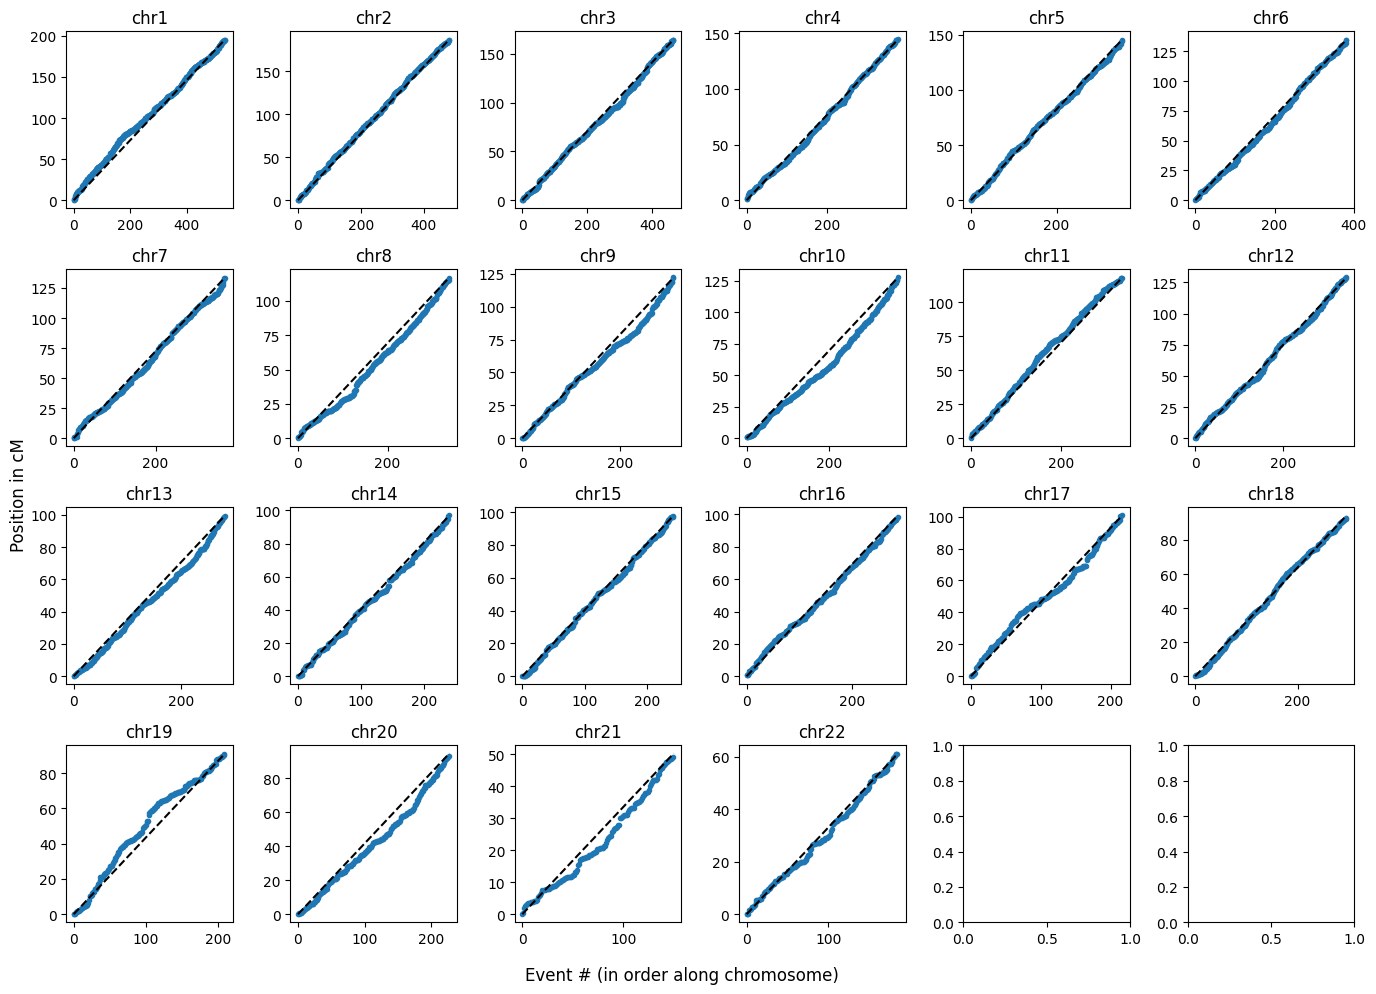

In [29]:
show_co_map(sample_ids, show_ks=False)

## Just Rahbari

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

kses = []
for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], tqdm.tqdm(aut_chrom_names)):
    df = (dense_reads_with_detection_df
        .filter(pl.col("sample_id").is_in(rahbari_sample_ids))
        .filter(pl.col("high_quality_classification_class") == "CO")
        .filter(pl.col("chrom") == chrom)
        .sort("grch37_reference_start_cM")
        .drop_nulls("grch37_reference_start_cM")
    )

    midpoints_in_cms = np.sort((df["grch37_reference_start_cM"] + df["grch37_reference_end_cM"])/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    kses.append(ks_pvalue)
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

combined = scipy.stats.combine_pvalues(kses).pvalue
fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle(f"Crossovers, combined p={combined:1.2f}");
    
plt.tight_layout()

## Just Sudmant

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

kses = []
for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], tqdm.tqdm(aut_chrom_names)):
    df = (dense_reads_with_detection_df
        .filter(pl.col("sample_id").is_in(sudmant_sample_ids))
        .filter(pl.col("high_quality_classification_class") == "CO")
        .filter(pl.col("chrom") == chrom)
        .sort("grch37_reference_start_cM")
        .drop_nulls("grch37_reference_start_cM")
    )

    midpoints_in_cms = np.sort((df["grch37_reference_start_cM"] + df["grch37_reference_end_cM"])/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    kses.append(ks_pvalue)
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

combined = scipy.stats.combine_pvalues(kses).pvalue
fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle(f"Crossovers, combined p={combined:1.2f}");
    
plt.tight_layout()

# Compare CO distribution between samples

## Across all of detectable interval

In [10]:
pairwise_co_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms = 1000,
    take_log10 = False,
)

100%|██████████| 105/105 [00:34<00:00,  3.05it/s]


In [21]:
pairwise_co_df.sort("AD_perm_pvalue").head()

sample_id1,sample_id2,paper_label_id1,paper_label_id2,n1,n2,ks_pvalue,AD_perm_pvalue
str,str,str,str,i64,i64,f64,f64
"""115980""","""PD50489e""","""AA9""","""AA4""",339,384,0.003476,0.0
"""115980""","""PD50523b""","""AA9""","""AD""",339,729,1.9632e-27,0.0
"""1894""","""PD46180c""","""AA5""","""AA2-t1""",400,595,0.009564,0.0
"""1894""","""PD50489e""","""AA5""","""AA4""",400,384,0.000358,0.0
"""1894""","""PD50521e""","""AA5""","""AN-s2""",400,486,0.005137,0.0


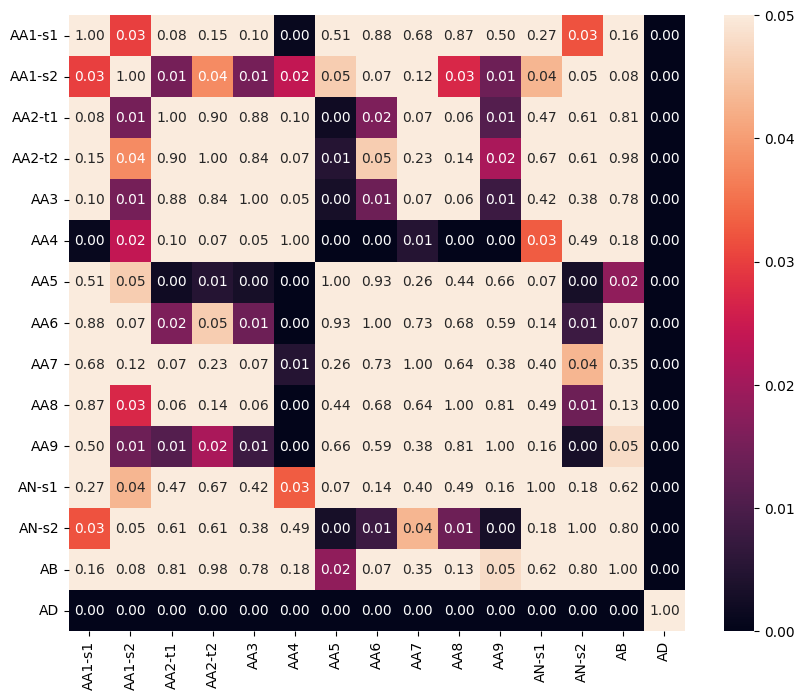

In [11]:
inference.plot_pairwise_results(
    pairwise_co_df,
    sample_presentation_order[:-1],
    column = "AD_perm_pvalue",
    vmax = 0.05,
    show_paper_labels = True,
)

## Across the recombining interval

In [23]:
pairwise_co_recomb_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    n_perms = 1000,
    take_log10 = False,
)

100%|██████████| 105/105 [00:38<00:00,  2.76it/s]
/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:1677: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pairwise_df = pl.DataFrame(


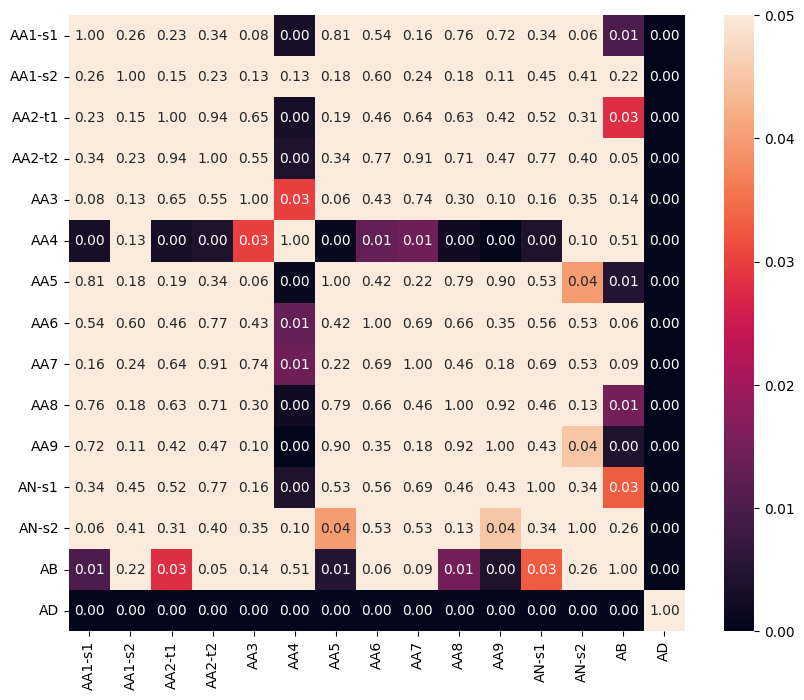

In [24]:
inference.plot_pairwise_results(
    pairwise_co_recomb_df,
    sample_presentation_order[:-1],
    column = "AD_perm_pvalue",
    vmax = 0.05,
    show_paper_labels = True,
)

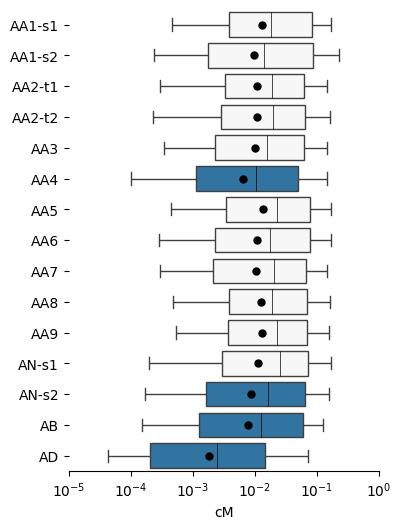

In [12]:
ax = inference.plot_boxplots_samples(
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    xlabel = "cM",
    take_log10=True,
    figsize=(4, 6),
    ticks = np.arange(-5, 1),
    label_to_color={
        "AD": CO_color,
        "AB": CO_color,
        "AN-s2": CO_color,
        "AA4": CO_color,
    }
);


## Within AAs

In [20]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s][:2] == "AA"],
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    n_perms = 10000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:   42.9s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   3 out of  11 | elapsed:   48.6s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  1.1min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:  1.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:  1.1min remaining:   56.8s
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:  1.1min remaining:   39.3s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:  1.1min remaining:   25.8s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:  1.2min remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  1.2min finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50489e""","""AA4""",384,0.0,0.0002,0.080702
"""1894""","""AA5""",400,0.0105,0.1075,0.109347
"""115980""","""AA9""",339,0.0255,0.1961,0.502982
"""PD50508b""","""AA1-s1""",318,0.029,0.1813,0.394362
"""PD50477f""","""AA3""",539,0.0318,0.3105,0.07012
"""PD50508f""","""AA1-s2""",98,0.0476,0.1971,0.112154
"""PD46180c""","""AA2-t1""",595,0.1293,0.6041,0.724467
"""95619""","""AA8""",345,0.1666,0.4813,0.885541
"""7899""","""AA7""",408,0.1892,0.6269,0.805431


## Check if AD, AB, AN is different than all the AA-s except AA4

In [17]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s][:2] in ["AA", "AD"] and sample_id_to_paper_label[s] != "AA4"],
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    n_perms = 10000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:  1.0min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  1.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  1.1min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  1.2min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.2min remaining:   51.2s
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:  1.2min remaining:   37.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  1.2min remaining:   24.9s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.2min remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.4min finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""115980""","""AA9""",339,0.0,0.0021,0.091608
"""1894""","""AA5""",400,0.0,0.0005,0.006182
"""3898""","""AA6""",343,0.0,0.0723,0.06317
"""7899""","""AA7""",408,0.0,0.0747,0.396234
"""95619""","""AA8""",345,0.0,0.0051,0.248265
"""PD46180c""","""AA2-t1""",595,0.0,0.0107,0.318675
"""PD50477f""","""AA3""",539,0.0,0.1141,0.56674
"""PD50489e""","""AA4""",384,0.0,0.0977,0.46467
"""PD50508b""","""AA1-s1""",318,0.0,0.0025,0.065583


In [18]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s][:2] in ["AA", "AB"] and sample_id_to_paper_label[s] != "AA4"],
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    n_perms = 10000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   44.2s remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   45.2s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   47.5s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   58.4s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:   59.2s remaining:   59.2s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.0min remaining:   44.0s
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:  1.0min remaining:   31.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  1.1min remaining:   21.8s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.1min remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.2min finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""2895""","""AB""",297,0.0,0.0146,0.16973
"""PD50489e""","""AA4""",384,0.0,0.0005,0.100878
"""1894""","""AA5""",400,0.0006,0.0679,0.086233
"""115980""","""AA9""",339,0.0028,0.1385,0.43928
"""PD50508b""","""AA1-s1""",318,0.0044,0.1435,0.340866
"""PD50477f""","""AA3""",539,0.0271,0.4382,0.092969
"""95619""","""AA8""",345,0.0395,0.3549,0.804666
"""PD50508f""","""AA1-s2""",98,0.043,0.2022,0.099187
"""PD46180c""","""AA2-t1""",595,0.0489,0.562,0.831371


In [11]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if (sample_id_to_paper_label[s][:2] in ["AA"] or sample_id_to_paper_label[s] == "AN-s1") and sample_id_to_paper_label[s] != "AA4"],
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    6.7s remaining:   30.4s
[Parallel(n_jobs=-1)]: Done   3 out of  11 | elapsed:    7.2s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    7.6s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    7.6s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    8.3s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    8.4s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    8.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    8.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    9.2s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50508f""","""AA1-s2""",98,0.079,0.182,0.142839
"""PD50477f""","""AA3""",539,0.099,0.143,0.036337
"""PD50508b""","""AA1-s1""",318,0.383,0.315,0.525681
"""1894""","""AA5""",400,0.392,0.259,0.176025
"""115980""","""AA9""",339,0.477,0.346,0.655656
"""PD46180c""","""AA2-t1""",595,0.636,0.512,0.512274
"""7899""","""AA7""",408,0.647,0.532,0.623754
"""PD50521b""","""AN-s1""",232,0.708,0.434,0.39823
"""3898""","""AA6""",343,0.883,0.725,0.545963


In [12]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if (sample_id_to_paper_label[s][:2] in ["AA"] or sample_id_to_paper_label[s] == "AN-s2") and sample_id_to_paper_label[s] != "AA4"],
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_recombining_interval_cM",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    4.4s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done   3 out of  11 | elapsed:    5.1s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    5.4s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    5.9s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    6.0s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    7.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    7.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    7.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    8.1s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50521e""","""AN-s2""",486,0.051,0.081,0.871992
"""PD50508f""","""AA1-s2""",98,0.089,0.182,0.131851
"""PD50477f""","""AA3""",539,0.108,0.195,0.047034
"""1894""","""AA5""",400,0.155,0.182,0.151025
"""PD50508b""","""AA1-s1""",318,0.236,0.234,0.478236
"""115980""","""AA9""",339,0.242,0.27,0.600818
"""7899""","""AA7""",408,0.572,0.604,0.686621
"""PD46180c""","""AA2-t1""",595,0.576,0.556,0.584808
"""95619""","""AA8""",345,0.749,0.605,0.998943


## Across the recombining interval, cM/Mb

In [32]:
pairwise_co_recomb_rate_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df.filter(pl.col("CO_active_interval_crossover_prob").is_not_null()),
    "grch37_cM_per_bp_across_recombining_interval",
    n_perms = 1000,
    take_log10 = False,
)

100%|██████████| 105/105 [00:24<00:00,  4.29it/s]
/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:1677: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pairwise_df = pl.DataFrame(


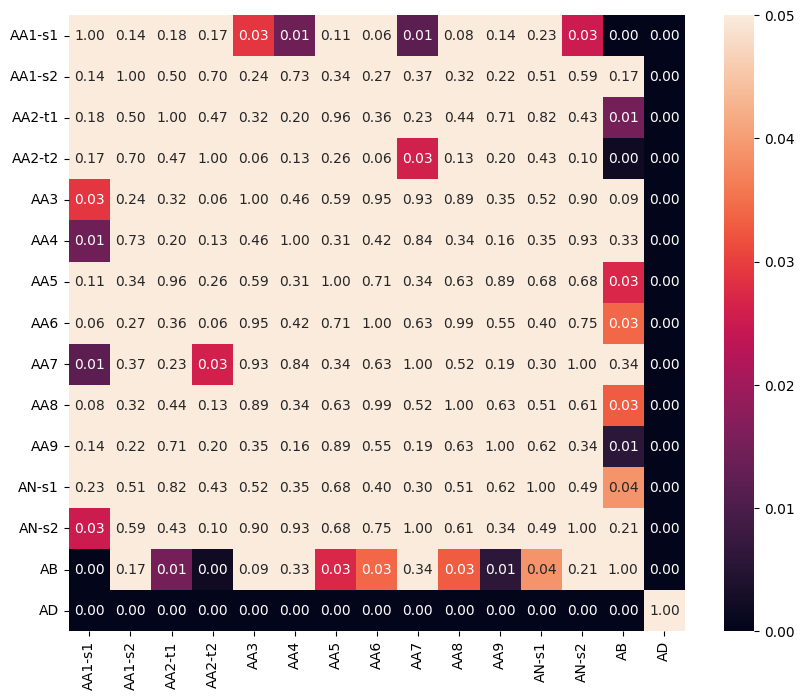

In [33]:
inference.plot_pairwise_results(
    pairwise_co_recomb_rate_df,
    sample_presentation_order[:-1],
    column = "AD_perm_pvalue",
    vmax = 0.05,
    show_paper_labels = True,
)

# Test one sample vs the rest

## All

In [34]:
sample_vs_rest_df = inference.get_sample_vs_rest_tests(
    sample_id_order,
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms=10000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  1.1min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:  1.1min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.2min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:  1.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:  1.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.2min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  2.1min remaining:   45.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed

/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:1780: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  sample_vs_rest_signal_df = pl.DataFrame(


In [35]:
sample_vs_rest_df.sort("AD_perm_pvalue")

sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""115980""","""AA9""",339,0.0,0.0003,0.025975
"""1894""","""AA5""",400,0.0,0.0,0.000187
"""2895""","""AB""",297,0.0,0.8735,0.972106
"""3898""","""AA6""",343,0.0,0.0011,0.000631
"""7899""","""AA7""",408,0.0,0.0142,0.006249
"""95619""","""AA8""",345,0.0,0.0021,0.106283
"""PD46180c""","""AA2-t1""",471,0.0,0.4754,0.471804
"""PD50477f""","""AA3""",412,0.0,0.1664,0.108026
"""PD50489e""","""AA4""",293,0.0,0.4675,0.745914


## Incremental analysis, Rahbari data

In [24]:
sample_vs_rest_except_df = inference.get_sample_vs_rest_tests(
    [k for k,v in sample_id_to_paper_label.items() if v[:2] in ["AD", "AA"] and k in rahbari_sample_ids],
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms=10000,
)

sample_vs_rest_except_df.sort("AD_perm_pvalue")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:   31.7s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:   34.2s remaining:   45.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   34.3s remaining:   25.7s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:   34.5s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   44.1s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD46180c""","""AA2-t1""",595,0.0,0.0,0.029377
"""PD50477f""","""AA3""",539,0.0,0.0002,0.154059
"""PD50489e""","""AA4""",384,0.0,0.6677,0.486392
"""PD50508b""","""AA1-s1""",318,0.0,0.0,0.000376
"""PD50508f""","""AA1-s2""",98,0.0,0.005,0.000246
"""PD50519d""","""AA2-t2""",520,0.0,0.0,0.017492
"""PD50523b""","""AD""",729,0.0,0.0,9.9905e-24


In [25]:
sample_vs_rest_except_df = inference.get_sample_vs_rest_tests(
    [k for k,v in sample_id_to_paper_label.items() if v[:2] in ["AN", "AA"] and k in rahbari_sample_ids],
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms=10000,
)

sample_vs_rest_except_df.sort("AD_perm_pvalue")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   31.6s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   34.8s remaining:   58.1s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   35.6s remaining:   35.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   39.7s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   40.1s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   44.6s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50508f""","""AA1-s2""",98,0.0,0.0179,0.010577
"""PD50489e""","""AA4""",384,0.0001,0.0168,0.220721
"""PD50508b""","""AA1-s1""",318,0.0003,0.0244,0.095906
"""PD50477f""","""AA3""",539,0.0605,0.4855,0.343216
"""PD50521b""","""AN-s1""",232,0.0662,0.2799,0.9794
"""PD50521e""","""AN-s2""",486,0.0895,0.5129,0.900145
"""PD46180c""","""AA2-t1""",595,0.1162,0.7771,0.704839
"""PD50519d""","""AA2-t2""",520,0.1707,0.909,0.999219


In [88]:
sample_vs_rest_except_df = inference.get_sample_vs_rest_tests(
    [k for k,v in sample_id_to_paper_label.items() if v[:2] == "AA" and k in rahbari_sample_ids],
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms=1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.1s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


In [89]:
sample_vs_rest_except_df.sort("AD_perm_pvalue")

sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50521e""","""AN-s2""",486,0.476,0.274,0.847151
"""PD50521b""","""AN-s1""",232,0.506,0.34,0.812394
"""PD50477f""","""AA3""",539,0.826,0.726,0.512751
"""PD46180c""","""AA2-t1""",595,0.946,0.928,0.974508
"""PD50519d""","""AA2-t2""",520,0.946,0.935,0.735376


## Incremental analysis, Sudmant data

In [85]:
sample_vs_rest_except_df = inference.get_sample_vs_rest_tests(
    [k for k,v in sample_id_to_paper_label.items() if k in sudmant_sample_ids],
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms=1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    2.3s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    2.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.4s finished


In [86]:
sample_vs_rest_except_df.sort("AD_perm_pvalue")

sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""2895""","""AB""",297,0.009,0.027,0.047567
"""1894""","""AA5""",400,0.186,0.217,0.229823
"""115980""","""AA9""",339,0.386,0.395,0.960018
"""7899""","""AA7""",408,0.599,0.682,0.834537
"""3898""","""AA6""",343,0.653,0.724,0.283042
"""95619""","""AA8""",345,0.663,0.808,0.512435


In [83]:
sample_vs_rest_except_df = inference.get_sample_vs_rest_tests(
    [k for k,v in sample_id_to_paper_label.items() if v not in ["AB"] and k in sudmant_sample_ids],
    CO_df,
    "CO_active_interval_crossover_prob",
    n_perms=1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.8s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


In [84]:
sample_vs_rest_except_df.sort("AD_perm_pvalue")

sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""7899""","""AA7""",408,0.632,0.343,0.858086
"""1894""","""AA5""",400,0.717,0.434,0.413364
"""115980""","""AA9""",339,0.826,0.62,0.692658
"""95619""","""AA8""",345,0.885,0.701,0.316231
"""3898""","""AA6""",343,0.947,0.888,0.470083


In [ ]:
import statsmodels.stats.multitest

statsmodels.stats.multitest.multipletests(
    pvals = sample_vs_rest_except_df.sort("AD_perm_pvalue")["AD_perm_pvalue"],
    method = "bonferroni",
)

In [ ]:
scipy.stats.combine_pvalues([0.012, 0.024])

## Plot particular examples

In [12]:
def plot_cm_diffs(
    label_list1,
    label_list2,
    label_legend1 = "",
    label_legend2 = "",
    ax = None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    sample_ids1 = [k for k,v in sample_id_to_paper_label.items() if v in label_list1]
    sample_ids2 = [k for k,v in sample_id_to_paper_label.items() if v in label_list2]
    
    if label_legend1 == "":
        label_legend1 = ', '.join(sample_ids1)
    if label_legend2 == "":
        label_legend2 = ', '.join(sample_ids1)

    x1 = pd.Series(np.log10(CO_df.filter(pl.col("sample_id").is_in(sample_ids1))["CO_active_interval_crossover_prob"] * 1e2), name=label_legend1)
    x2 = pd.Series(np.log10(CO_df.filter(pl.col("sample_id").is_in(sample_ids2))["CO_active_interval_crossover_prob"] * 1e2), name=label_legend2)

    sns.histplot(
        data = [x1, x2],
        bins=25, #np.linspace(0, 2, 25),
        multiple="dodge",
        shrink=0.8,
        stat="proportion",
        common_norm=False,
        ax=ax,
    )
    
    sns.despine(ax=ax)

    ax.set_xlabel("Genetic length (cM)");
    ax.set_xticks(
        ticks = np.arange(-7, 1),
        labels = [f"$10^{{{x}}}$" for x in np.arange(-7, 1)],
    );

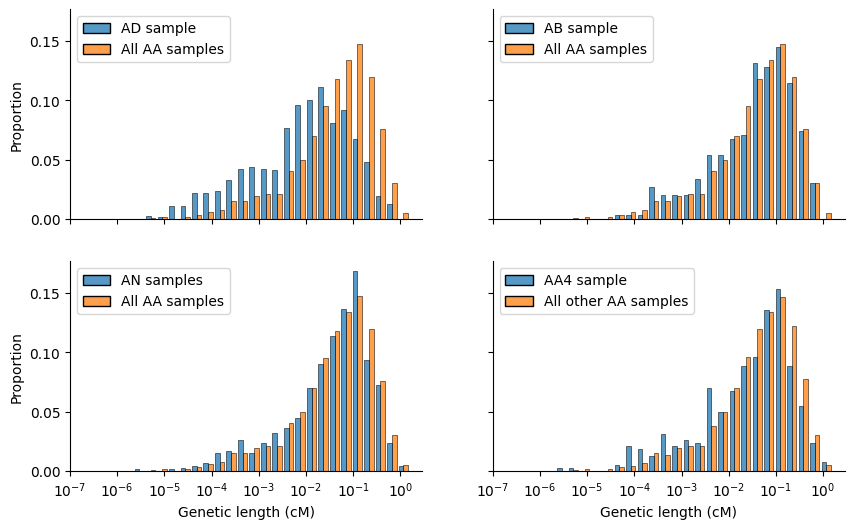

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

plot_cm_diffs(
    ["AD"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label],
    label_legend1 = "AD sample",
    label_legend2 = "All AA samples",
    ax = axs[0,0],
)

plot_cm_diffs(
    ["AB"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label],
    label_legend1 = "AB sample",
    label_legend2 = "All AA samples",
    ax = axs[0,1],
)


plot_cm_diffs(
    ["AN-s1", "AN-s2"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label],
    label_legend1 = "AN samples",
    label_legend2 = "All AA samples",
    ax = axs[1,0],
)


plot_cm_diffs(
    ["AA4"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA4"]],
    label_legend1 = "AA4 sample",
    label_legend2 = "All other AA samples",
    ax = axs[1,1],
)

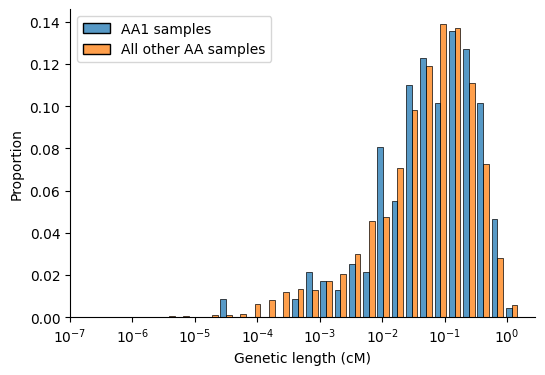

In [18]:
plot_cm_diffs(
    ["AA1-s1", "AA1-s2"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA1-s1", "AA1-s2"]],
    label_legend1 = "AA1 samples",
    label_legend2 = "All other AA samples",
)

## Big transparent plot?

In [ ]:
def get_data(label_list, name):
    sample_ids = [k for k,v in sample_id_to_paper_label.items() if v in label_list]
    x = pd.Series(np.log10(CO_df.filter(pl.col("sample_id").is_in(sample_ids))["CO_active_interval_crossover_prob"] * 1e2), name=name)
    return x

fig, ax = plt.subplots(figsize=(8, 6))

data = [
#    get_data(["AA1-s1", "AA1-s2"], "AA1 samples"),
    get_data(
        [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA1-s1", "AA1-s2"]],
        "All other AA samples",
    ),
    get_data(["AN-s1", "AN-s2"], "AN samples"),
    get_data(["AB"], "AB"),
    get_data(["AD"], "AD"),
]

sns.histplot(
    data = data,
    bins=np.linspace(-5.5, 0.2, 25), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    #palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
# ax.legend(
#     ax.get_legend().legend_handles, 
#     ["CO reads", "NCO reads", "All reads"], 
#     loc="upper left",
# );

ax.spines[['right', 'top']].set_visible(False)

# *** Pretty plot for differences

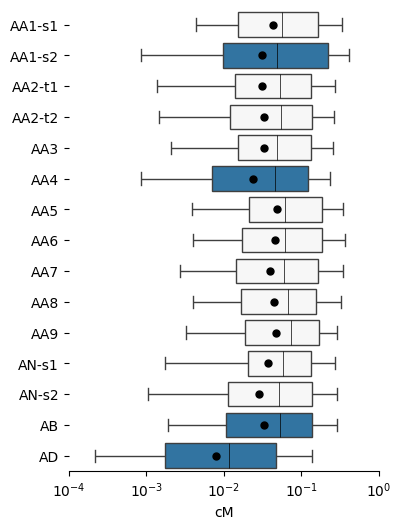

In [15]:
ax = inference.plot_boxplots_samples(
    CO_df.with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2),
    "cM",
    xlabel = "cM",
    take_log10=True,
    figsize=(4, 6),
    ticks = np.arange(-4, 1),
    label_to_color={
        "AB": CO_color,
        "AD": CO_color,
#        "AA1-s1": CO_color,
        "AA4": CO_color,        
        "AA1-s2": CO_color,
    }
);


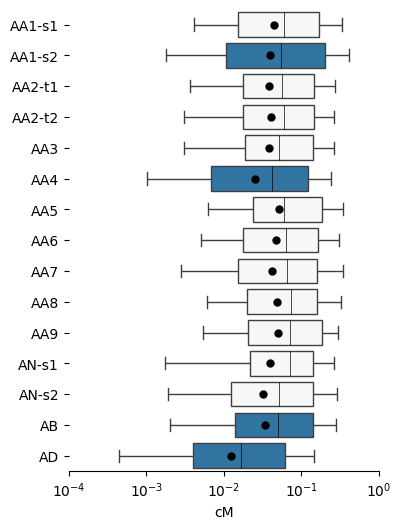

In [16]:
ax = inference.plot_boxplots_samples(
    CO_clean_df.with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2),
    "cM",
    xlabel = "cM",
    take_log10=True,
    figsize=(4, 6),
    ticks = np.arange(-4, 1),
    label_to_color={
        "AB": CO_color,
        "AD": CO_color,
#        "AA1-s1": CO_color,
        "AA4": CO_color,        
        "AA1-s2": CO_color,
    }
);


# DSBs

## Overall rates

### A/A

In [31]:
print("Fraction of CO reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .filter(pl.col("high_quality_classification_class") == "CO")
    .select(pl.col("AA_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of CO reads with motif in them: 0.6712507237984945


In [10]:
print("Fraction of all reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())                                                    
    .select(pl.col("AA_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of all reads with motif in them: 0.1355114820686847


In [32]:
print("Fraction of CO reads with motif in recombining region:", (CO_df
    .filter(pl.col("grch38_reference_start").is_not_null())                                                            
    .select(
        (pl.col("grch38_recombining_interval_start_pos") <= pl.col("AA_motif_center_pos")) &
        (pl.col("grch38_recombining_interval_end_pos") > pl.col("AA_motif_center_pos"))
    )
    .mean().item(0,0)
))

Fraction of CO reads with motif in recombining region: 0.5814011468461731


## Overall distances to motif center

### A/A

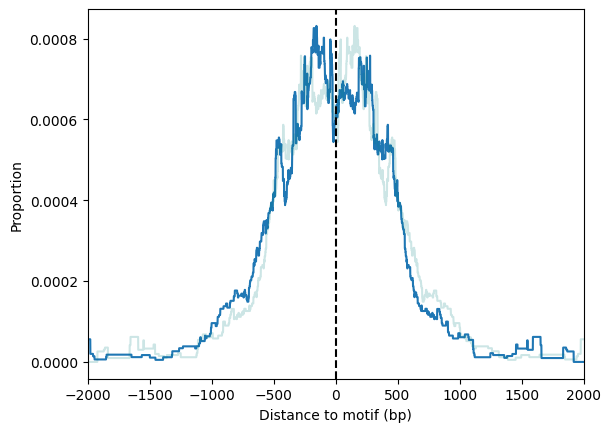

In [19]:
xs, H = inference.calculate_motif_distance_histogram(
    (CO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    grch38_recombining_interval_threshold = 500,
)

plt.plot(xs, H);
plt.plot(xs, H[::-1], color="teal", alpha=0.2);

plt.xlim(-2000,2000);
plt.axvline(0, color="black", ls="--");
plt.xlabel("Distance to motif (bp)");
plt.ylabel("Proportion");

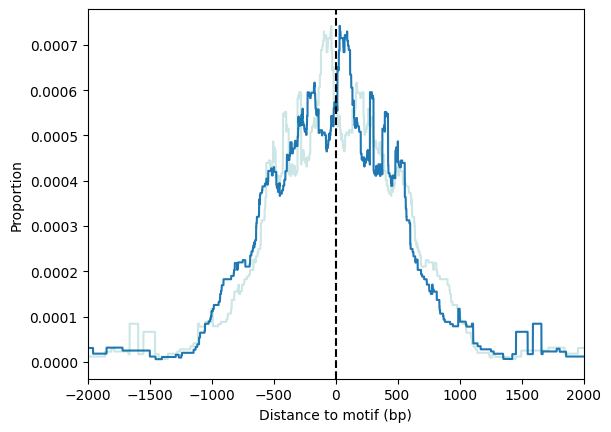

In [52]:
xs, H = inference.calculate_motif_distance_histogram(
    (CO_with_flow_cells_df
        .filter(pl.col("flow_cell_type") == "sequel_ii")
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    grch38_recombining_interval_threshold = 1000,
)

plt.plot(xs, H);
plt.plot(xs, H[::-1], color="teal", alpha=0.2);

plt.xlim(-2000,2000);
plt.axvline(0, color="black", ls="--");
plt.xlabel("Distance to motif (bp)");
plt.ylabel("Proportion");

In [ ]:
%%time
inference.motif_distance_histogram_symmetry_permutation_testing(
    (CO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    n_perms=100,
    grch38_recombining_interval_threshold = 500,
    stat = "max_abs",
)

In [50]:
%%time
inference.motif_distance_histogram_symmetry_permutation_testing(
    (CO_with_flow_cells_df
        .filter(pl.col("flow_cell_type") == "revio_unbinned")
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    n_perms=100,
    grch38_recombining_interval_threshold = 500,
    stat = "max_abs",
)

CPU times: user 1.47 s, sys: 23.7 ms, total: 1.5 s
Wall time: 1.48 s


np.float64(0.63)

## Distance to motif centers, per sample

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(8, 6))

motif_distances_per_sample_id = {}

for ax, sample_id in zip(axs.ravel(), tqdm.tqdm(sample_id_order)):
    xs, H = inference.calculate_motif_distance_histogram(
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id)
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    pval = inference.motif_distance_histogram_symmetry_permutation_testing(
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id) 
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    motif_distances_per_sample_id[sample_id] = H

    ax.plot(xs, H, label=sample_id);
    ax.set_title(f"{sample_id}, p={pval}")
    ax.set_xlim(-500,500)
    ax.set_ylim(0, 0.0006);

fig.tight_layout()

# Compare distance to motif between samples, in COs

In [ ]:
rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    pval = inference.motif_distance_histogram_diffs_permutation_testing(
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id1) & (pl.col("high_quality_classification_class") == "CO"))
        ),
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id2) & (pl.col("high_quality_classification_class") == "CO"))
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        max_dist=30000,
        n_perms=100,
        stat="sum_abs",
    )
    
    rows.append(
        [
            sample_id1, 
            sample_id2,
            pval,
        ]
    )
    
pairwise_motif_dists_co_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "perm_pval"
           ],
)       

In [ ]:
pairwise_motif_dists_co_df.sort("perm_pval").head()

# Compare DSB signal strengths between COs

In [28]:
sample_id_to_AA_heats = {}

for sample_id in sample_ids:
    sdf = (dense_reads_with_detection_df
        .filter(pl.col("total_mismatches") == 0) #### TODO: MOVE OUT
        .filter(pl.col("grch38_reference_start").is_not_null())           
        .filter((pl.col("sample_id") == sample_id) & (pl.col("high_quality_classification_class") == "CO"))
    )
    heats = sdf["AA_heat"].fill_null(0)
    sample_id_to_AA_heats[sample_id] = heats.to_numpy()

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    heats_1 = sample_id_to_AA_heats[sample_id1]
    heats_2 = sample_id_to_AA_heats[sample_id2]
    rows.append(
        [
            sample_id1, 
            sample_id2,
            len(heats_1), 
            len(heats_2),
            scipy.stats.ks_2samp(heats_1, heats_2).pvalue,
            inference.permutation_testing([[heats_1, heats_2]], 1000),
            inference.permutation_testing([[heats_1[heats_1>0], heats_2[heats_2>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_1==0).sum(), (heats_1!=0).sum()],
                 [(heats_2==0).sum(), (heats_2!=0).sum()]],
            ).pvalue,
        ]
    )
    
pairwise_AA_heats_co_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "n1", "n2", 
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

100%|██████████| 105/105 [01:09<00:00,  1.52it/s]
/tmp/ipykernel_1193658/2873054162.py:32: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pairwise_AA_heats_co_df = pl.DataFrame(


## Matrix

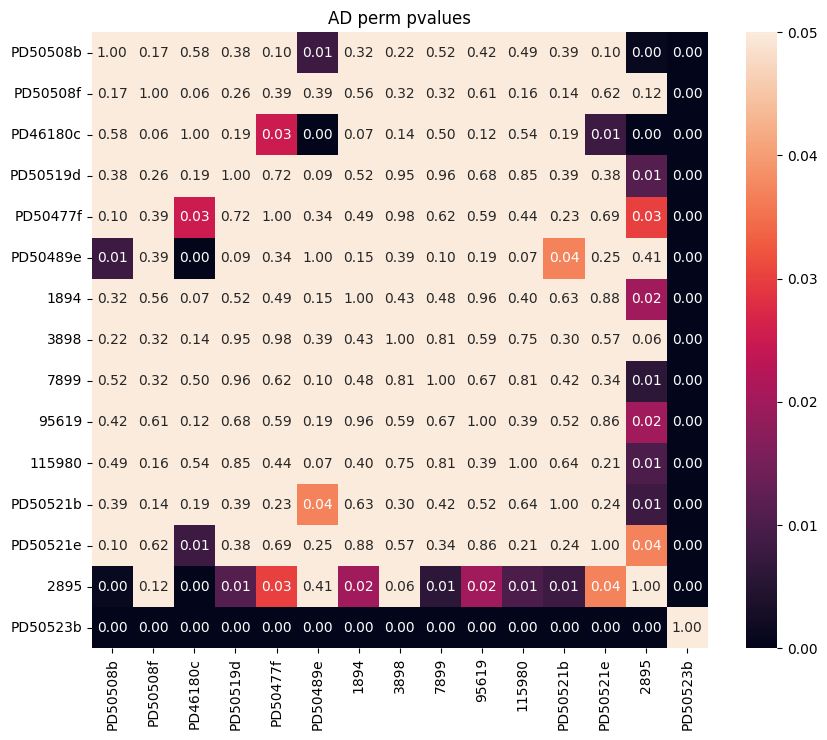

In [29]:
mat = []
for sample_id1 in sample_id_order:
    row = []
    for sample_id2 in sample_id_order:
        if sample_id1 == sample_id2:
            pval = 1
        else:
            pval = pairwise_AA_heats_co_df.filter(
                ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
                ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
            )["heats_AD_perm_pvalue"].item(0)
        row.append(pval)
    mat.append(row)
    
mat = pd.DataFrame(mat, index=sample_id_order, columns=sample_id_order)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(
    mat,
    vmin=0, 
    vmax=0.05,
    annot=True,
    fmt=".2f",
    square=True,
);

plt.title("AD perm pvalues");

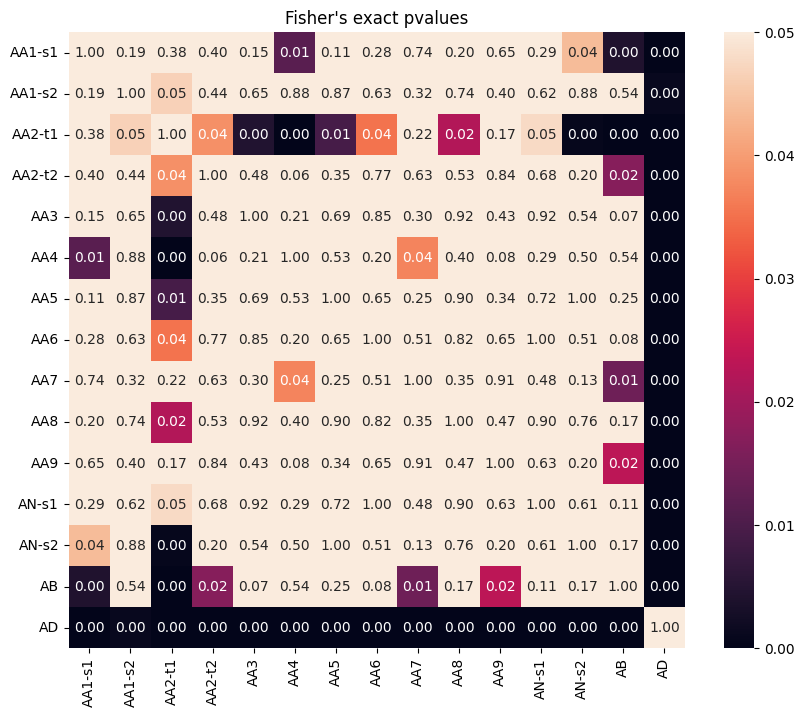

In [30]:
mat = []
for sample_id1 in sample_presentation_order[:-1]:
    row = []
    for sample_id2 in sample_presentation_order[:-1]:
        if sample_id1 == sample_id2:
            pval = 1
        else:
            pval = pairwise_AA_heats_co_df.filter(
                ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
                ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
            )["heats_fisher_pvalue"].item(0)
        row.append(pval)
    mat.append(row)
    
labels = [sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]]
mat = pd.DataFrame(mat, index=labels, columns=labels)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(
    mat,
    vmin=0, 
    vmax=0.05,
    annot=True,
    fmt=".2f",
    square=True,    
);

plt.title("Fisher's exact pvalues");

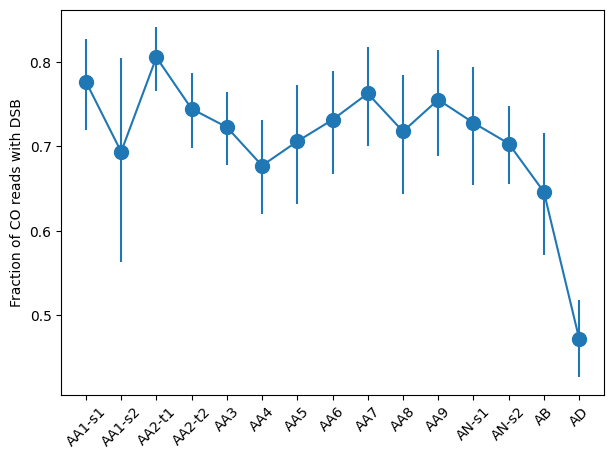

In [31]:
fig, ax = plt.subplots(figsize=(7,5))

mns = [(sample_id_to_AA_heats[s]>0).mean() for s in sample_presentation_order[:-1]]
cis = [statsmodels.stats.proportion.proportion_confint(
    (sample_id_to_AA_heats[s]>0).sum(),
    len(sample_id_to_AA_heats[s]),
    method="beta",
) for s in sample_presentation_order[:-1]]
    


ax.errorbar(
    x = np.arange(len(sample_presentation_order[:-1])),
    y = mns,
    yerr = [
        [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis, mns)],
        [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis, mns)],
    ],
    fmt=".-",
    ms=20,
    
);
ax.set_xticks(
    ticks = np.arange(len(sample_id_order)), 
    labels=[sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]], 
    rotation=45
);
ax.set_ylabel("Fraction of CO reads with DSB");

### Sample vs. rest

In [95]:
def test_fishers_exact_one_vs_rest(sample_ids):
    rows = []
    for sample_id in tqdm.tqdm(sample_ids):
        xx = sample_id_to_AA_heats[sample_id]
        sx = (xx>0).sum()
        yy = np.concatenate([sample_id_to_AA_heats[s] for s in sample_ids if s != sample_id])
        sy = (yy>0).sum()
        
        pval = scipy.stats.fisher_exact(
            [[sx, len(xx)-sx], [sy, len(yy)-sy]]
        ).pvalue
        
        label_id = sample_id_to_paper_label[sample_id]
        rows.append([sample_id, label_id, sx/len(xx), sy/len(yy), pval])
    
    df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "prop", "other_prop", "fisher_pval"]).sort("fisher_pval")
    return df
    

In [96]:
test_fishers_exact_one_vs_rest(sample_ids)

100%|██████████| 15/15 [00:00<00:00, 333.44it/s]
/tmp/ipykernel_2380152/1987253663.py:16: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "prop", "other_prop", "fisher_pval"]).sort("fisher_pval")


sample_id,paper_label,prop,other_prop,fisher_pval
str,str,f64,f64,f64
"""PD50523b""","""AD""",0.436905,0.703691,2.2812e-50
"""PD46180c""","""AA2-t1""",0.773585,0.659913,6.5203e-10
"""PD50508b""","""AA1-s1""",0.749333,0.666769,0.000836
"""3898""","""AA6""",0.721925,0.66835,0.031598
"""115980""","""AA9""",0.713904,0.668809,0.079206
"""PD50519d""","""AA2-t2""",0.702875,0.668099,0.081847
"""7899""","""AA7""",0.708145,0.668729,0.09396
"""PD50521b""","""AN-s1""",0.714815,0.669479,0.128579
"""1894""","""AA5""",0.697727,0.66945,0.228158


In [111]:
test_fishers_exact_one_vs_rest([s for s in rahbari_sample_ids if sample_id_to_paper_label[s] not in ["AD", "AA2-t1", "AA1-s1"]]
                              )

100%|██████████| 6/6 [00:00<00:00, 324.16it/s]
/tmp/ipykernel_2380152/1987253663.py:16: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "prop", "other_prop", "fisher_pval"]).sort("fisher_pval")


sample_id,paper_label,prop,other_prop,fisher_pval
str,str,f64,f64,f64
"""PD50489e""","""AA4""",0.657895,0.690064,0.184013
"""PD50521b""","""AN-s1""",0.714815,0.681092,0.269596
"""PD50519d""","""AA2-t2""",0.702875,0.678854,0.278996
"""PD50521e""","""AN-s2""",0.673358,0.687441,0.535914
"""PD50508f""","""AA1-s2""",0.663636,0.685433,0.675175
"""PD50477f""","""AA3""",0.6859375,0.68408,0.961061


In [112]:
test_fishers_exact_one_vs_rest(sudmant_sample_ids)

100%|██████████| 6/6 [00:00<00:00, 382.04it/s]
/tmp/ipykernel_2380152/1987253663.py:16: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "prop", "other_prop", "fisher_pval"]).sort("fisher_pval")


sample_id,paper_label,prop,other_prop,fisher_pval
str,str,f64,f64,f64
"""2895""","""AB""",0.655689,0.704455,0.082371
"""3898""","""AA6""",0.721925,0.692929,0.269962
"""115980""","""AA9""",0.713904,0.694444,0.462233
"""95619""","""AA8""",0.682051,0.700611,0.469368
"""7899""","""AA7""",0.708145,0.695084,0.605556
"""1894""","""AA5""",0.697727,0.697492,1.0


In [97]:
def test_combined_fishers_exact_one_vs_rest(sample_ids):
    rows = []
    for sample_id in tqdm.tqdm(sample_ids):
        pvals = (pairwise_AA_heats_co_df
            .filter((pl.col("sample_id1") == sample_id) | (pl.col("sample_id2") == sample_id))
            ["heats_fisher_pvalue"]
        )
        
        comb_fisher = scipy.stats.combine_pvalues(pvals, method="fisher").pvalue
        
        label_id = sample_id_to_paper_label[sample_id]
        rows.append([sample_id, label_id, comb_fisher])
    
    df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "comb_fisher"]).sort("comb_fisher")
    return df
    
    

In [98]:
test_combined_fishers_exact_one_vs_rest(sample_ids)

100%|██████████| 15/15 [00:00<00:00, 725.73it/s]
/tmp/ipykernel_2380152/899869762.py:14: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "comb_fisher"]).sort("comb_fisher")


sample_id,paper_label,comb_fisher
str,str,f64
"""PD50523b""","""AD""",3.4258e-237
"""PD46180c""","""AA2-t1""",3.1464e-54
"""PD50508b""","""AA1-s1""",2.0764e-23
"""PD50519d""","""AA2-t2""",3.1895e-17
"""PD50477f""","""AA3""",4.4294e-16
"""PD50521e""","""AN-s2""",1.4653e-14
"""3898""","""AA6""",1.6572e-14
"""PD50489e""","""AA4""",2.3659e-14
"""7899""","""AA7""",1.1489e-13


In [99]:
test_combined_fishers_exact_one_vs_rest(rahbari_sample_ids)

100%|██████████| 9/9 [00:00<00:00, 823.17it/s]
/tmp/ipykernel_2380152/899869762.py:14: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "comb_fisher"]).sort("comb_fisher")


sample_id,paper_label,comb_fisher
str,str,f64
"""PD50523b""","""AD""",3.4258e-237
"""PD46180c""","""AA2-t1""",3.1464e-54
"""PD50508b""","""AA1-s1""",2.0764e-23
"""PD50519d""","""AA2-t2""",3.1895e-17
"""PD50477f""","""AA3""",4.4294e-16
"""PD50521e""","""AN-s2""",1.4653e-14
"""PD50489e""","""AA4""",2.3659e-14
"""PD50521b""","""AN-s1""",3.4772e-9
"""PD50508f""","""AA1-s2""",0.005419


In [103]:
test_combined_fishers_exact_one_vs_rest([s for s in rahbari_sample_ids if sample_id_to_paper_label[s] not in ["AA1-s1", "AD", "AA4", "AA2-t1"]])

100%|██████████| 5/5 [00:00<00:00, 878.72it/s]
/tmp/ipykernel_2380152/899869762.py:14: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "comb_fisher"]).sort("comb_fisher")


sample_id,paper_label,comb_fisher
str,str,f64
"""PD50519d""","""AA2-t2""",3.1895e-17
"""PD50477f""","""AA3""",4.4294e-16
"""PD50521e""","""AN-s2""",1.4653e-14
"""PD50521b""","""AN-s1""",3.4772e-9
"""PD50508f""","""AA1-s2""",0.005419


In [104]:
test_combined_fishers_exact_one_vs_rest(sudmant_sample_ids)

100%|██████████| 6/6 [00:00<00:00, 680.69it/s]
/tmp/ipykernel_2380152/899869762.py:14: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "comb_fisher"]).sort("comb_fisher")


sample_id,paper_label,comb_fisher
str,str,f64
"""3898""","""AA6""",1.6572e-14
"""7899""","""AA7""",1.1489e-13
"""115980""","""AA9""",1.3353e-12
"""1894""","""AA5""",2.2700e-12
"""2895""","""AB""",2.0330e-11
"""95619""","""AA8""",1.2467e-10


In [105]:
test_combined_fishers_exact_one_vs_rest([s for s in sudmant_sample_ids if sample_id_to_paper_label[s] not in ["AB"]])


100%|██████████| 5/5 [00:00<00:00, 755.19it/s]
/tmp/ipykernel_2380152/899869762.py:14: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "comb_fisher"]).sort("comb_fisher")


sample_id,paper_label,comb_fisher
str,str,f64
"""3898""","""AA6""",1.6572e-14
"""7899""","""AA7""",1.1489e-13
"""115980""","""AA9""",1.3353e-12
"""1894""","""AA5""",2.2700e-12
"""95619""","""AA8""",1.2467e-10


## Look at some examples

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sample_id1 = "PD50508f"
sample_id2 = "PD50521e"

pval = pairwise_AA_heats_co_df.filter(
    ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
    ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
)["heats_AD_perm_pvalue"].item(0)

sns.histplot(
    [
        pd.Series(sample_id_to_AA_heats[sample_id1], name=sample_id1),
        pd.Series(sample_id_to_AA_heats[sample_id2], name=sample_id2),
    ], 
    bins=50, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("AA heat");
plt.title(f"AD perm pval = {pval}");


# Pratto et al. DSBs

In [ ]:
pratto_df = pd.read_csv(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/06.hotspots/pratto_2014_hotspots.tsv",
    delim_whitespace = True,
    comment = "#",
)

In [ ]:
intersection_df = (
    pl.from_dataframe(
        pybedtools.BedTool.from_dataframe(
            CO_df
                .select("chrom", "grch37_recombining_interval_start_pos", "grch37_recombining_interval_end_pos", "read_name")
                .sort("chrom", "grch37_recombining_interval_start_pos", "grch37_recombining_interval_end_pos")
                .to_pandas()
        ).intersect(
            pybedtools.BedTool.from_dataframe(
                pratto_df[["chrom", "start", "end", "AA1_strength"]].sort_values(["chrom", "start"])
            ),
            wao=True,
        )
        .to_dataframe()
    )
    .with_columns(
        AA1_heat_signal = pl.col("thickEnd").cast(pl.Int32, strict=False)
    )
    .select(
        "chrom", 
        "start", 
        "end", 
        pl.col("name").alias("read_name"), 
        pl.col("itemRgb").alias("n_intersect"), 
        "AA1_heat_signal",
        (pl.col("end") - pl.col("start")).alias("n_total")
    )
)

pratto_AA1_df = (intersection_df
    .with_columns(times = pl.col("AA1_heat_signal") * pl.col("n_intersect"))
    .group_by("read_name", "n_total")
    .agg(pl.col("times").sum())
    .with_columns(AA1_heat_average = pl.col("times") / pl.col("n_total"))
    .select("read_name", "AA1_heat_average")
)

In [ ]:
intersection_df = (
    pl.from_dataframe(
        pybedtools.BedTool.from_dataframe(
            CO_df
                .select("chrom", "grch37_recombining_interval_start_pos", "grch37_recombining_interval_end_pos", "read_name")
                .sort("chrom", "grch37_recombining_interval_start_pos", "grch37_recombining_interval_end_pos")
                .to_pandas()
        ).intersect(
            pybedtools.BedTool.from_dataframe(
                pratto_df[["chrom", "start", "end", "AA2_strength"]].sort_values(["chrom", "start"])
            ),
            wao=True,
        )
        .to_dataframe()
    )
    .with_columns(
        AA2_heat_signal = pl.col("thickEnd").cast(pl.Int32, strict=False)
    )
    .select(
        "chrom", 
        "start", 
        "end", 
        pl.col("name").alias("read_name"), 
        pl.col("itemRgb").alias("n_intersect"), 
        "AA2_heat_signal",
        (pl.col("end") - pl.col("start")).alias("n_total")
    )
)

pratto_AA2_df = (intersection_df
    .with_columns(times = pl.col("AA2_heat_signal") * pl.col("n_intersect"))
    .group_by("read_name", "n_total")
    .agg(pl.col("times").sum())
    .with_columns(AA2_heat_average = pl.col("times") / pl.col("n_total"))
    .select("read_name", "AA2_heat_average")
)

In [ ]:
pairwise_pratto_aa1_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df.join(pratto_AA1_df, on="read_name", how="left").fill_null(0),
    "AA1_heat_average",
    n_perms = 1000,
    take_log10 = False,
)

In [ ]:
pairwise_pratto_aa2_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df.join(pratto_AA2_df, on="read_name", how="left").fill_null(0),
    "AA2_heat_average",
    n_perms = 1000,
    take_log10 = False,
)

In [ ]:
pairwise_pratto_aa1_df.sort("AD_perm_pvalue").head(10)

In [ ]:
pairwise_pratto_aa2_df.sort("AD_perm_pvalue").head(10)

In [ ]:
inference.plot_pairwise_results(
    pairwise_pratto_aa1_df,
    sample_presentation_order[:-1],
)

In [ ]:
inference.plot_pairwise_results(
    pairwise_pratto_aa2_df,
    sample_presentation_order[:-1],
)

In [ ]:
sample_id_to_has_AA1_frac = dict(
    (CO_df
        .join(pratto_AA1_df, on="read_name", how="left").fill_null(0)
        .group_by("sample_id")
        .agg((pl.col("AA1_heat_average")>0).cast(pl.Int32).mean().alias("has_AA1_heat"))
    )
    .rows()
)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

mns = [sample_id_to_has_AA1_frac[s] for s in sample_presentation_order[:-1]]
# cis = [statsmodels.stats.proportion.proportion_confint(
#     (sample_id_to_AA_heats[s]>0).sum(),
#     len(sample_id_to_AA_heats[s]),
#     method="beta",
# ) for s in sample_id_order]
    


ax.plot(
    np.arange(len(sample_id_order)),
    mns,
    # yerr = [
    #     [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis, mns)],
    #     [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis, mns)],
    # ],
    '.-',
    #fmt=".-",
    ms=20,
    
);
ax.set_xticks(ticks = np.arange(len(sample_presentation_order[:-1])), labels=sample_presentation_order[:-1], rotation=45);
ax.set_ylabel("Fraction of CO reads with DSB");

# Distance to telomeres

$Pr(dist|detected) \propto Pr(detected|dist)Pr(dist)$

$Pr(dist) \approx $ (num of reads in dist)/(num total reads) \propto (num of reads in dist)

$Pr(detected|dist) \approx \frac{1}{\text{num of reads in dist}}\sum_{read\ in\ dist}{Pr(detected|read)}$ \Rightarrow

$Pr(dist|detected) \propto \sum_{read\ in\ dist}{Pr(detected|read)}$ (???)

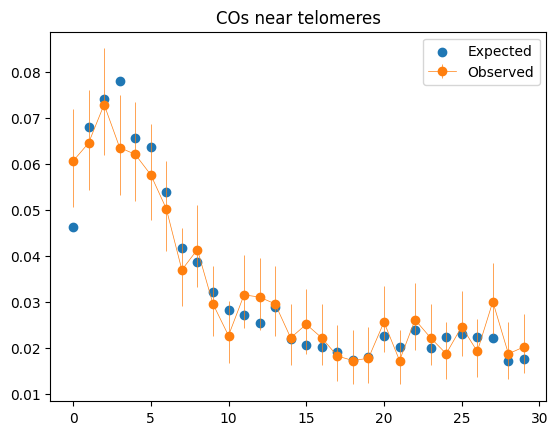

In [125]:
exp_df = (dense_reads_with_detection_df
    .filter(pl.col("grch37_reference_start") < 30e6)
    .with_columns(
        rounded_grch37_reference_start = (pl.col("grch37_reference_start") // (1e6)).cast(pl.Int64),
    )
    .group_by("rounded_grch37_reference_start")
    .agg(pl.col("CO_active_interval_crossover_prob").sum().alias("exp"))
    .sort("rounded_grch37_reference_start")
    .with_columns(
        exp = pl.col("exp") / pl.col("exp").sum()
    )
)

obs_df = (CO_df
    .filter(pl.col("grch37_reference_start") < 30e6)
    .with_columns(
        rounded_grch37_reference_start = (pl.col("grch37_reference_start") // (1e6)).cast(pl.Int64),
    )
    .group_by("rounded_grch37_reference_start")
    .len()
    .sort("rounded_grch37_reference_start")
    .with_columns(
        obs = pl.col("len") / pl.col("len").sum()
    )
)

n_total = len(CO_df
    .filter(pl.col("grch37_reference_start") < 30e6)
)

low_ci, high_ci = statsmodels.stats.proportion.proportion_confint(
    obs_df["len"], n_total, alpha=0.05, method='beta'
)

plt.scatter(
    exp_df["rounded_grch37_reference_start"],
    exp_df["exp"],
    label="Expected",
)

plt.errorbar(
    x=obs_df["rounded_grch37_reference_start"],
    y=obs_df["obs"],
    yerr=[obs_df["obs"]-low_ci, high_ci-obs_df["obs"]],
    color="C1",
    label="Observed",
    fmt='-o',
    lw=0.5,
)

plt.legend();
plt.title("COs near telomeres");

# ENCODE H3K4me3

In [114]:
pairwise_co_signals_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
)

100%|██████████| 105/105 [00:43<00:00,  2.44it/s]
/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/src/inference.py:1677: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pairwise_df = pl.DataFrame(


In [115]:
pairwise_co_signals_df.sort("AD_perm_pvalue").head()

sample_id1,sample_id2,paper_label_id1,paper_label_id2,n1,n2,ks_pvalue,AD_perm_pvalue
str,str,str,str,i64,i64,f64,f64
"""3898""","""PD50523b""","""AA6""","""AD""",343,729,NaN,0.012
"""115980""","""PD50523b""","""AA9""","""AD""",339,729,NaN,0.03
"""95619""","""PD50523b""","""AA8""","""AD""",345,729,NaN,0.037
"""1894""","""PD50523b""","""AA5""","""AD""",400,729,NaN,0.042
"""3898""","""PD50489e""","""AA6""","""AA4""",343,384,NaN,0.056


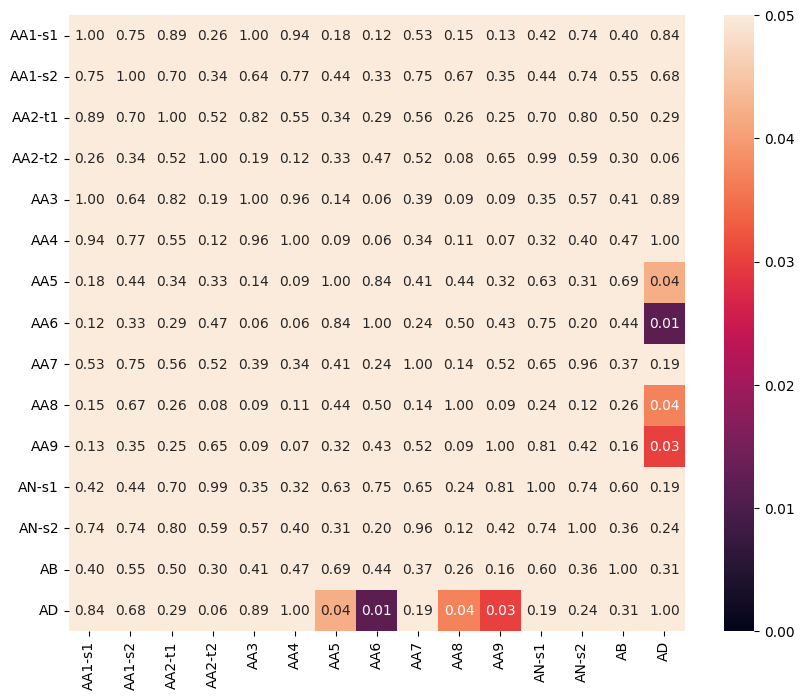

In [116]:
inference.plot_pairwise_results(pairwise_co_signals_df, sample_presentation_order[:-1], vmax=0.05)

In [118]:
inference.get_sample_vs_rest_tests(
    sample_ids,
    CO_df,
    "H3K4me3_signal_mean",
    n_perms = 100,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   31.1s remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:   31.5s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   31.5s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:   31.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   31.5s remaining:   47.3s
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:   31.6s remaining:   36.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   31.6s remaining:   27.6s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:   31.6s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   31.6s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:   31.6s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapse

sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50523b""","""AD""",729,0.01,0.05,NaN
"""115980""","""AA9""",339,0.03,0.11,NaN
"""95619""","""AA8""",345,0.04,0.08,NaN
"""3898""","""AA6""",343,0.07,0.09,NaN
"""1894""","""AA5""",400,0.22,0.16,NaN
"""PD50489e""","""AA4""",384,0.23,0.25,NaN
"""PD50519d""","""AA2-t2""",520,0.28,0.23,NaN
"""PD50477f""","""AA3""",539,0.4,0.33,NaN
"""2895""","""AB""",297,0.59,0.44,NaN


In [123]:
inference.get_sample_vs_rest_tests(
    rahbari_sample_ids,
    CO_df,
    "H3K4me3_signal_mean",
    n_perms = 100,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   26.8s finished
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   30.0s remaining:   59.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   30.0s remaining:   37.5s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   30.0s remaining:   24.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   30.1s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   30.1s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   30.2s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50519d""","""AA2-t2""",520,0.27,0.1,NaN
"""PD50523b""","""AD""",729,0.45,0.23,NaN
"""PD50521b""","""AN-s1""",232,0.75,0.51,NaN
"""PD50489e""","""AA4""",384,0.88,0.64,NaN
"""PD50521e""","""AN-s2""",486,0.88,0.59,NaN
"""PD50508f""","""AA1-s2""",98,0.91,0.52,NaN
"""PD50477f""","""AA3""",539,0.94,0.84,NaN
"""PD46180c""","""AA2-t1""",595,0.96,0.82,NaN
"""PD50508b""","""AA1-s1""",318,0.99,0.92,NaN


In [124]:
inference.get_sample_vs_rest_tests(
    sudmant_sample_ids,
    CO_df,
    "H3K4me3_signal_mean",
    n_perms = 100,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    2.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    2.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.9s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""95619""","""AA8""",345,0.14,0.18,NaN
"""115980""","""AA9""",339,0.27,0.25,NaN
"""7899""","""AA7""",408,0.3,0.24,NaN
"""2895""","""AB""",297,0.37,0.27,NaN
"""3898""","""AA6""",343,0.62,0.64,NaN
"""1894""","""AA5""",400,0.78,0.86,NaN


In [119]:
def plot_h3k4_diffs(
    label_list1,
    label_list2,
    label_legend1 = "",
    label_legend2 = "",
    ax = None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    sample_ids1 = [k for k,v in sample_id_to_paper_label.items() if v in label_list1]
    sample_ids2 = [k for k,v in sample_id_to_paper_label.items() if v in label_list2]
    
    if label_legend1 == "":
        label_legend1 = ', '.join(sample_ids1)
    if label_legend2 == "":
        label_legend2 = ', '.join(sample_ids1)

    x1 = pd.Series(np.log10(CO_df.filter(pl.col("sample_id").is_in(sample_ids1))["H3K4me3_signal_mean"]), name=label_legend1)
    x2 = pd.Series(np.log10(CO_df.filter(pl.col("sample_id").is_in(sample_ids2))["H3K4me3_signal_mean"]), name=label_legend2)

    sns.histplot(
        data = [x1, x2],
        bins = np.linspace(-1, 1.5, 25),
        multiple="dodge",
        shrink=0.8,
        stat="proportion",
        common_norm=False,
        ax=ax,
    )
    
    sns.despine(ax=ax)

    ax.set_xlabel("H3K4me4 signal average across read");
    ax.set_xticks(
        ticks = np.arange(-1, 2, 1),
        labels = [f"$10^{{{x}}}$" for x in np.arange(-1, 2, 1)],
    );

/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1458: RuntimeWarning: divide by zero encountered in log10
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1458: RuntimeWarning: divide by zero encountered in log10
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),


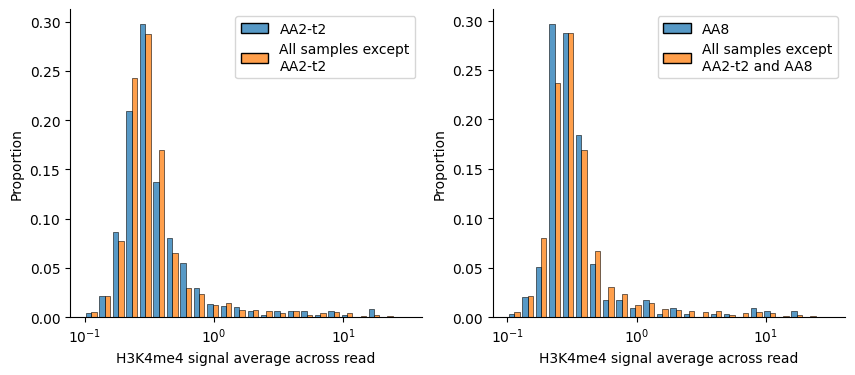

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plot_h3k4_diffs(
    ["AA2-t2"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA2-t2"]],
    label_legend1 = "AA2-t2",
    label_legend2 = "All samples except\nAA2-t2",
    ax = axs[0]
)

plot_h3k4_diffs(
    ["AA8"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA8", "AA2-t2"]],
    label_legend1 = "AA8",
    label_legend2 = "All samples except\nAA2-t2 and AA8",
    ax = axs[1]
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [k for k,v in sample_id_to_paper_label.items() if v not in ["AA2-t2"]],
    CO_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
)

In [ ]:
plot_h3k4_diffs(
    ["AA8"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA2-t2", "AA8"]],
    label_legend1 = "AA8",
    label_legend2 = "All other samples except AA2-t2",
)

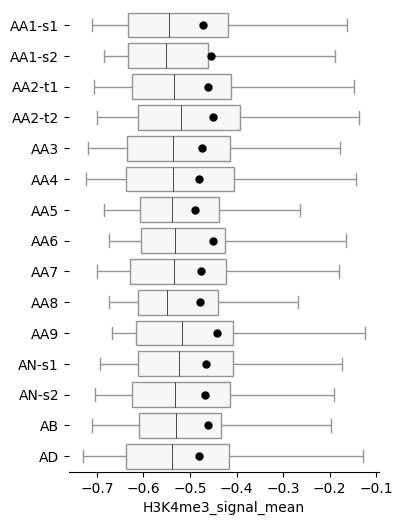

In [122]:
ax = inference.plot_boxplots_samples(
    CO_df,
    "H3K4me3_signal_mean",
    xlabel = "H3K4me3_signal_mean",
    take_log10=True,
    figsize=(4, 6),
    #ticks = np.arange(-1, 1),
    label_to_color={
        # "AA6": CO_color,
        # "AA8": CO_color,
        # "AA2-t2": CO_color,
    }
);


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

focal_sample_id = "95619"
other_focal_sample_id = "7899"

sns.histplot(
    [
        # pd.Series(CO_df.filter(pl.col("sample_id") != focal_sample_id)["H3K4me3_signal_mean"].log10(), 
        #           name="All others"),
        pd.Series(CO_df.filter(pl.col("sample_id") == focal_sample_id)["H3K4me3_signal_mean"].log10(), 
                  name=sample_id_to_paper_label[focal_sample_id]),        
        pd.Series(CO_df.filter(pl.col("sample_id") == other_focal_sample_id)["H3K4me3_signal_mean"].log10(), 
                  name=sample_id_to_paper_label[other_focal_sample_id]),
    ], 
    bins=np.linspace(-1,1,50),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Mean signal in detectible interval");


In [ ]:
inference.get_sample_vs_all_tests(
    sample_ids,
    CO_df,
    dense_reads_with_detection_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
    subsample_fraction = 0.001,
)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

focal_sample_id = "PD50521e"

sns.histplot(
    [
        pd.Series(dense_reads_with_detection_df["H3K4me3_signal_mean"][::100], name="All reads"),
        pd.Series(CO_df.filter(pl.col("sample_id") == focal_sample_id)["H3K4me3_signal_mean"], 
                  name=sample_id_to_paper_label[focal_sample_id]),
    ], 
    bins=np.linspace(0,1,50),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Mean signal in detectible interval");


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

focal_sample_id = "PD50519d"

sns.histplot(
    [
        pd.Series(CO_df.filter(pl.col("sample_id") != focal_sample_id)["H3K4me3_signal_mean"], 
                  name="All others"),
        pd.Series(CO_df.filter(pl.col("sample_id") == focal_sample_id)["H3K4me3_signal_mean"], 
                  name=sample_id_to_paper_label[focal_sample_id]),
    ], 
    bins=np.linspace(0,1,50),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Mean signal in detectible interval");


# ENCODE CTCF

In [ ]:
pairwise_co_signals_df = inference.get_sample_pairwise_tests(
    sample_ids,
    CO_df,
    "CTCF_signal_mean",
    n_perms = 1000,
)

In [ ]:
pairwise_co_signals_df.sort("AD_perm_pvalue")

In [ ]:
inference.plot_pairwise_results(pairwise_co_signals_df, sample_presentation_order[:-1], vmax=0.05)

In [ ]:
inference.get_sample_vs_rest_tests(
    sample_ids,
    CO_df,
    "CTCF_signal_mean",
    n_perms = 1000,
) 

In [ ]:
inference.get_sample_vs_all_tests(
    sample_ids,
    CO_df,
    dense_reads_with_detection_df[::100],
    "CTCF_signal_mean",
    n_perms = 1000,
) 

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

focal_sample_id = "PD46180c"

sns.histplot(
    [
        pd.Series(dense_reads_with_detection_df["CTCF_signal_mean"][::100], name="All reads"),
        pd.Series(CO_df.filter(pl.col("sample_id") == focal_sample_id)["CTCF_signal_mean"], 
                  name=sample_id_to_paper_label[focal_sample_id]),
    ], 
    bins=np.linspace(0,2,50),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Mean signal in detectible interval");


In [ ]:
def dropnan(x):
    return x[~np.isnan(x)]

In [ ]:
focal_sample_id = "PD50519d"

scipy.stats.ttest_ind(
    dropnan(CO_df.filter(pl.col("sample_id") != focal_sample_id)["H3K4me3_signal_mean"].to_numpy()),
    dropnan(CO_df.filter(pl.col("sample_id") == focal_sample_id)["H3K4me3_signal_mean"].to_numpy()),
)

In [ ]:
inference.plot_histograms_samples(
    CO_df,
    "CTCF_signal_mean",
    dense_reads_with_detection_df,
    bins = np.linspace(-0.8, 0.4, 25),
    ylim_max = 0.3,
    xlabel = "",
    take_log10=True,
);